# Curvas de supervivencia
Cuaderno para simular experimentos de supervivencia celular

Importación de móudlos

In [1]:
import matplotlib.pyplot as plt
from skimage.draw import disk
import numpy as np

Definimos las dimensiones del espacio para definir las cápsulas de Petri

In [2]:
base_size_pixel = 1000
base = np.zeros([base_size_pixel,base_size_pixel])

Definimos las dimensiones de la cápsula de Petri, la constante para convertir de centímetros a píxeles y las constantes de cada clonógeno

In [3]:
dish_r = 5 # cm
cm_px = 2 * dish_r / base_size_pixel # cm/pixel 

dish_value = 10 
dish_center_x, dish_center_y = dish_r, dish_r

clon_value = 60
clon_r = 0.2
clon_center_x, clon_center_y = dish_r, dish_r


Definimos un wraper de la utilidad de skimage para definir las coordenadas de un disco. El wraper devuelve las coordendas en centímetros

In [4]:
def disk_cm(c_list, r, px_cm = 1/cm_px):
    return disk([c_list[0]*px_cm, c_list[1]*px_cm], r*px_cm, shape=(base_size_pixel, base_size_pixel))

Función para obtener las coordenadas y la densidad de cada clon

In [5]:
def clon_f(num=100, sigma_size=0.3, sigma_density=0.05):
    rng = rng = np.random.default_rng()
    rhos = rng.uniform(0, dish_r, int(num))
    thetas = rng.uniform(0, 2*np.pi, int(num))
    sizes = rng.normal(1., sigma_size, int(num))
    densities = rng.normal(1., sigma_density, int(num))

    clon_center_xs = dish_r + rhos * np.cos(thetas)
    clon_center_ys = dish_r + rhos * np.sin(thetas)
    clon_rs = clon_r * sizes

    return clon_center_xs, clon_center_ys, clon_rs, densities

Función para obtener la fracción de supervivencia celular para una serie de dosis

In [6]:
def survival_f(D, alpha=0.1, beta=0.0, num=1.):
    return num * np.exp(-alpha*np.array(D)-beta*np.array(D)**2)

Función para representar la cápsula de Petri con la colección de clonógeno

In [7]:
def plot_dish(clon_center_xs, clon_center_ys, clon_rs, densities, ax, title=None):
    dish_xs, dish_ys = disk_cm((dish_center_x, dish_center_y), dish_r)

    base = np.zeros(2*[base_size_pixel])
    
    base[dish_xs, dish_ys] = dish_value

    for clon_center_x, clon_center_y, clon_r, density in zip(clon_center_xs, clon_center_ys, clon_rs, densities):
        clon_xs, clon_ys = disk_cm([clon_center_x, clon_center_y], clon_r)
        base[clon_xs, clon_ys] = clon_value * density

    print(type(ax))
    ax.imshow(base, cmap=plt.cm.gray_r);
    ax.set_axis_off()
    ax.set_title(title)

## Acumulación de daños celulares
### Experimento con alta LET

In [8]:
control_clon_center_xs, control_clon_center_ys, control_clon_rs, control_densities = clon_f()

Doses=np.array([0., 1., 2., 5., 10., 20., 30.,], dtype=int)

clons = [clon_f(num=survival_f(D=Dose, num=100)) for Dose in Doses]
SFs = survival_f(Doses)

<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


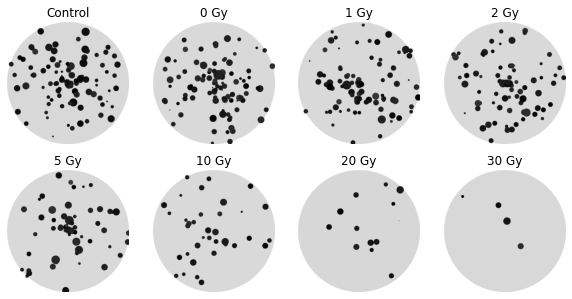

In [9]:
fig, axs = plt.subplots(ncols=4, nrows = 2, figsize=[10,5])
axs = axs.flatten()

plot_dish(clon_center_xs=control_clon_center_xs, clon_center_ys=control_clon_center_ys, clon_rs=control_clon_rs, densities=control_densities, ax=axs[0], title='Control')
for ax, [exp_clon_center_xs, exp_clon_center_ys, exp_clon_rs, exp_density], Dose in zip(axs[1:], clons, Doses):
    plot_dish(clon_center_xs=exp_clon_center_xs, clon_center_ys=exp_clon_center_ys, clon_rs=exp_clon_rs, densities=exp_density, ax=ax, title=f'{Dose} Gy')

plt.show()

<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


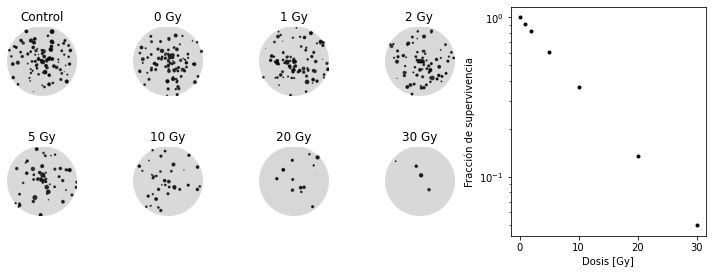

In [10]:
fig, axs = plt.subplot_mosaic([['Control', '0', '1', '2', 'SF', 'SF'], ['5', '10', '20', '30', 'SF', 'SF']], figsize=[10,4])

plot_dish(clon_center_xs=control_clon_center_xs, clon_center_ys=control_clon_center_ys, clon_rs=control_clon_rs, densities=control_densities, ax=axs['Control'], title='Control')
for [exp_clon_center_xs, exp_clon_center_ys, exp_clon_rs, exp_density], Dose in zip(clons, Doses):
    plot_dish(clon_center_xs=exp_clon_center_xs, clon_center_ys=exp_clon_center_ys, clon_rs=exp_clon_rs, densities=exp_density, ax=axs[str(Dose)], title=f'{Dose} Gy')

ax = axs['SF']
ax.plot(Doses, SFs, 'k.')
ax.set_xlabel('Dosis [Gy]')
ax.set_ylabel('Fracción de supervivencia')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

### Experimento con baja LET y $\alpha/\beta = 3$

In [11]:
alpha_3 = 0.01
beta_3 = 0.0033
clons_beta_3 = [clon_f(num=survival_f(D=Dose, alpha=alpha_3, beta=beta_3, num=100)) for Dose in Doses]
SFs_beta_3 = survival_f(Doses, alpha=alpha_3, beta=beta_3)

<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


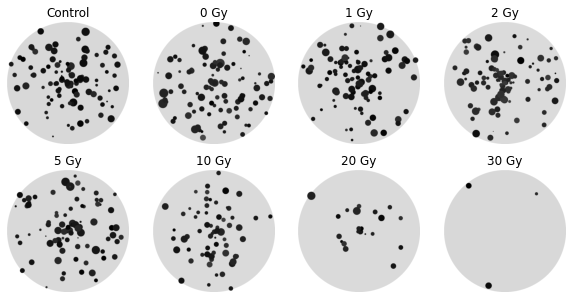

In [12]:
fig, axs = plt.subplots(ncols=4, nrows = 2, figsize=[10,5])
axs = axs.flatten()

plot_dish(clon_center_xs=control_clon_center_xs, clon_center_ys=control_clon_center_ys, clon_rs=control_clon_rs, densities=control_densities, ax=axs[0], title='Control')
for ax, [exp_clon_center_xs, exp_clon_center_ys, exp_clon_rs, exp_density], Dose in zip(axs[1:], clons_beta_3, Doses):
    plot_dish(clon_center_xs=exp_clon_center_xs, clon_center_ys=exp_clon_center_ys, clon_rs=exp_clon_rs, densities=exp_density, ax=ax, title=f'{Dose} Gy')

plt.show()

<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


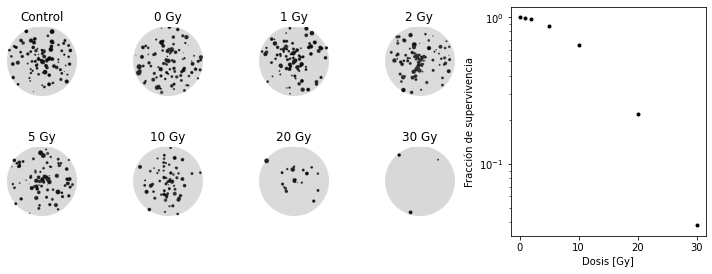

In [13]:
fig, axs = plt.subplot_mosaic([['Control', '0', '1', '2', 'SF', 'SF'], ['5', '10', '20', '30', 'SF', 'SF']], figsize=[10,4])

plot_dish(clon_center_xs=control_clon_center_xs, clon_center_ys=control_clon_center_ys, clon_rs=control_clon_rs, densities=control_densities, ax=axs['Control'], title='Control')
for [exp_clon_center_xs, exp_clon_center_ys, exp_clon_rs, exp_density], Dose in zip(clons_beta_3, Doses):
    plot_dish(clon_center_xs=exp_clon_center_xs, clon_center_ys=exp_clon_center_ys, clon_rs=exp_clon_rs, densities=exp_density, ax=axs[str(Dose)], title=f'{Dose} Gy')

ax = axs['SF']
ax.plot(Doses, SFs_beta_3, 'k.')
ax.set_xlabel('Dosis [Gy]')
ax.set_ylabel('Fracción de supervivencia')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

### Experimento con baja LET y $\alpha/\beta = 10$

In [14]:
alpha_10 = 0.03
beta_10 = 0.003
clons_beta_10 = [clon_f(num=survival_f(D=Dose, alpha=alpha_10, beta=beta_10, num=100)) for Dose in Doses]
SFs_beta_10 = survival_f(Doses, alpha=alpha_10, beta=beta_10)

<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


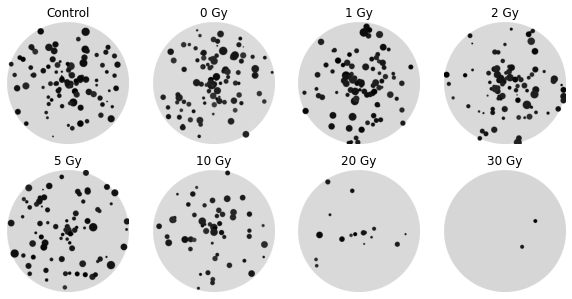

In [15]:
fig, axs = plt.subplots(ncols=4, nrows = 2, figsize=[10,5])
axs = axs.flatten()

plot_dish(clon_center_xs=control_clon_center_xs, clon_center_ys=control_clon_center_ys, clon_rs=control_clon_rs, densities=control_densities, ax=axs[0], title='Control')
for ax, [exp_clon_center_xs, exp_clon_center_ys, exp_clon_rs, exp_density], Dose in zip(axs[1:], clons_beta_10, Doses):
    plot_dish(clon_center_xs=exp_clon_center_xs, clon_center_ys=exp_clon_center_ys, clon_rs=exp_clon_rs, densities=exp_density, ax=ax, title=f'{Dose} Gy')

plt.show()

<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


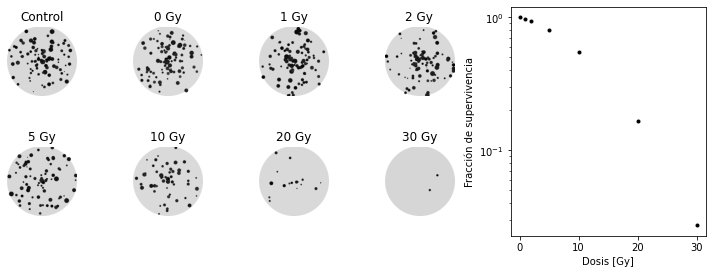

In [16]:
fig, axs = plt.subplot_mosaic([['Control', '0', '1', '2', 'SF', 'SF'], ['5', '10', '20', '30', 'SF', 'SF']], figsize=[10,4])

plot_dish(clon_center_xs=control_clon_center_xs, clon_center_ys=control_clon_center_ys, clon_rs=control_clon_rs, densities=control_densities, ax=axs['Control'], title='Control')
for [exp_clon_center_xs, exp_clon_center_ys, exp_clon_rs, exp_density], Dose in zip(clons_beta_10, Doses):
    plot_dish(clon_center_xs=exp_clon_center_xs, clon_center_ys=exp_clon_center_ys, clon_rs=exp_clon_rs, densities=exp_density, ax=axs[str(Dose)], title=f'{Dose} Gy')

ax = axs['SF']
ax.plot(Doses, SFs_beta_10, 'k.')
ax.set_xlabel('Dosis [Gy]')
ax.set_ylabel('Fracción de supervivencia')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

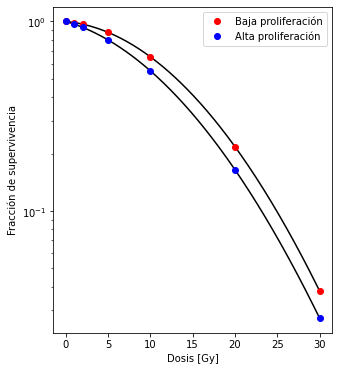

In [18]:
fig, ax = plt.subplots(figsize=(5, 6))
aDoses = np.linspace(0, 30, 300)
ax.plot(aDoses, survival_f(D=aDoses, alpha=alpha_3, beta=beta_3), 'k-')
ax.plot(aDoses, survival_f(D=aDoses, alpha=alpha_10, beta=beta_10), 'k-')
ax.plot(Doses, SFs_beta_3, 'ro', label='Baja proliferación')
ax.plot(Doses, SFs_beta_10, 'bo', label='Alta proliferación')
ax.set_xlabel('Dosis [Gy]')
ax.set_ylabel('Fracción de supervivencia')
ax.set_yscale('log')
ax.legend()
plt.show()